In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import dsa
from dsa import *
from datasets import image
from models import resnet
import pickle

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-03-02 16:33:40.093655: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 16:33:40.949679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20869 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [3]:
target_ds, aux_ds = image.load_celeba()

In [4]:
celeba_dsa = {}
log = {}

for split in [4]:
    make_f, make_g, make_e, make_d, make_c = resnet.make_resnet(split=split, class_num=2)
    celeba_dsa["celeba-split="+str(split)] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log["celea-split="+str(split)] = celeba_dsa["celeba-split="+str(split)].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        batch_size=64,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.0001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.002,
        iter_d=100,   # the number of iterations to train the decoder on auxiliary data
        w=500.,
        verbose=True,
        log_freq=100)

======Split level is 4======


2022-03-02 16:34:02.970074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-02 16:34:03.640330: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 16:34:03.641274: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 16:34:03.641295: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-02 16:34:03.642781: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 16:34:03.642862: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Iteration 100, average attack MSE: 0.34265693634748456
Iteration 200, average attack MSE: 0.2083036433160305
Iteration 300, average attack MSE: 0.14767830103635787
Iteration 400, average attack MSE: 0.09940255276858806
Iteration 500, average attack MSE: 0.07310571536421775
Iteration 600, average attack MSE: 0.06360288586467505
Iteration 700, average attack MSE: 0.061162756942212584
Iteration 800, average attack MSE: 0.0596872303634882
Iteration 900, average attack MSE: 0.056242382749915124
Iteration 1000, average attack MSE: 0.0564951242133975
Iteration 1100, average attack MSE: 0.054897188320755956
Iteration 1200, average attack MSE: 0.05695662777870893
Iteration 1300, average attack MSE: 0.055771762542426585
Iteration 1400, average attack MSE: 0.05542233429849148
Iteration 1500, average attack MSE: 0.05482451636344195


KeyboardInterrupt: 

In [40]:
with open('log/cat_dog-all.pkl', 'wb') as f:
    pickle.dump(log, f)

tf.Tensor(0.05389904, shape=(), dtype=float32)
tf.Tensor(0.06313035, shape=(), dtype=float32)
tf.Tensor(0.09318634, shape=(), dtype=float32)


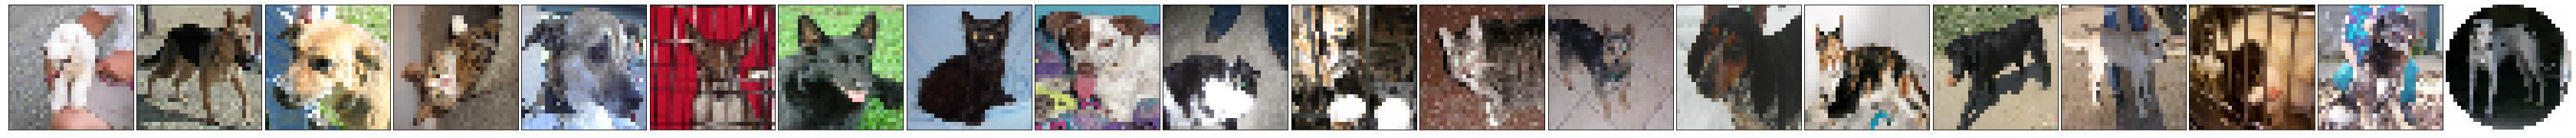

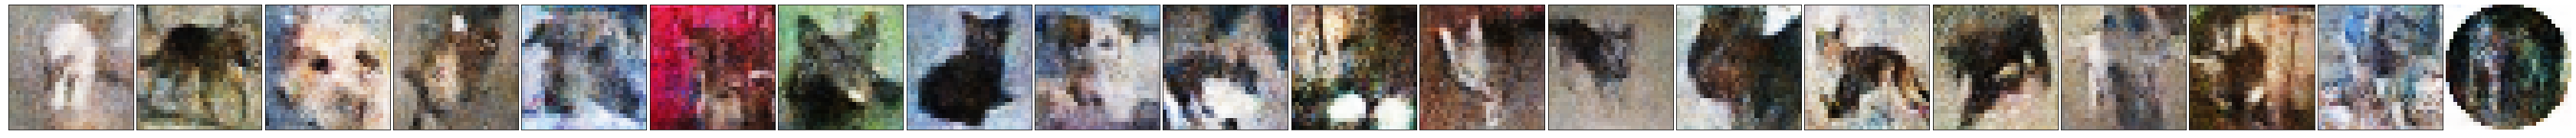

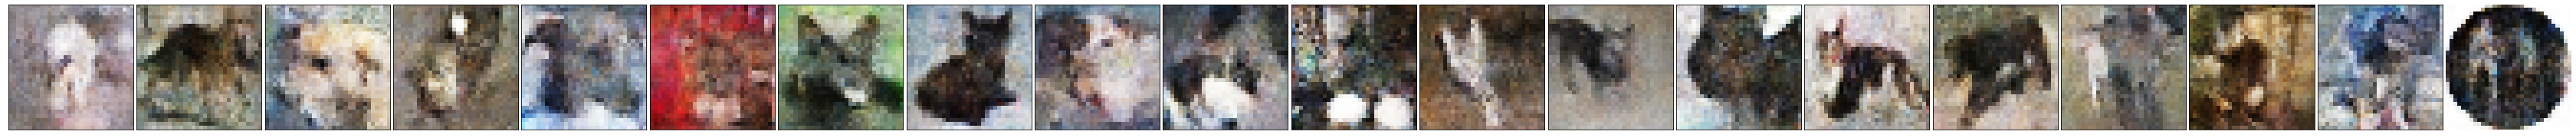

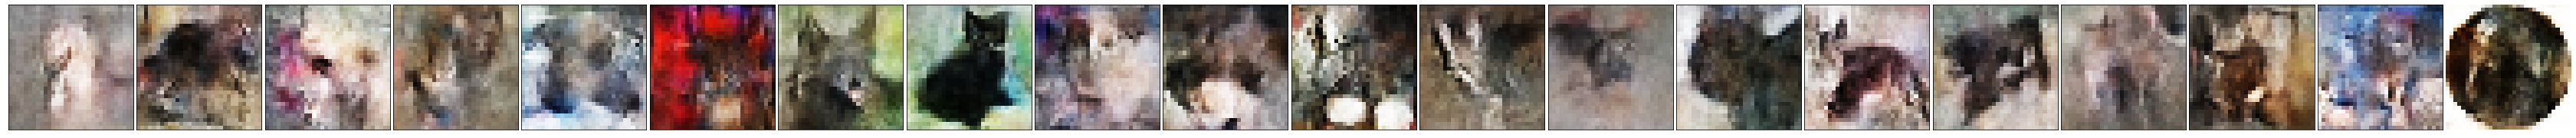

In [56]:
imgs = image.load_cat_vs_dog(take_first=20)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

fig = plot(imgs)
for split in [2,3,4]:
    flattened_z = cat_dog_dsa["cat_vs_dog-split="+str(split)].f(imgs, training=False).numpy().reshape((len(imgs), cat_dog_dsa["cat_vs_dog-split="+str(split)].flattened_inter_dim))
    rec_res = cat_dog_dsa["cat_vs_dog-split="+str(split)].d(flattened_z, training=False)
    fig = plot(rec_res)
    print(tf.keras.losses.MeanSquaredError()(imgs, rec_res))

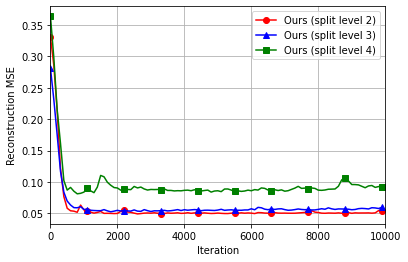

In [58]:
with open('log/cat_dog-all.pkl', 'rb') as f:
    log = pickle.load(f)

from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 100
# plt.yscale('logit')
plt.xlim([0,10000])
# plt.ylim([0.0, 0.5])
plt.grid()
# plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], labels=["0.05", "0.1", "0.15", "0.2", "0.25", "0.3", "0.35", "0.4"])
sampled_log_2 = [sum(log["cat_vs_dog-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cat_vs_dog-split=2"][:,0])/log_freq))]
sampled_log_3 = [sum(log["cat_vs_dog-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cat_vs_dog-split=3"][:,0])/log_freq))]
sampled_log_4 = [sum(log["cat_vs_dog-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cat_vs_dog-split=4"][:,0])/log_freq))]
ran = [i * log_freq for i in range(int(10000/log_freq))]
plt.plot(ran, sampled_log_2, 'ro-', ran, sampled_log_3, 'b^-', ran, sampled_log_4, 'gs-', markevery=11)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend(["Ours (split level 2)", "Ours (split level 3)", "Ours (split level 4)"])
plt.savefig("fig/cat_vs_dog-all.pdf", bbox_inches='tight')

Seems all right!